# Text Mining for ESG Score Analysis & Prediction : Using News data

## Import libraries

In [46]:
import sklearn
import random
import numpy as np
import pandas as pd
import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image #image 불러오기
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import re
import requests
#KoNLPy 공식 문서 : https://konlpy.org/ko/latest/
#설치되었는지 확인 : pip install konlpy
try:
  from konlpy.tag import Hannanum, Kkma, Komoran, Okt
except:
  !pip install konlpy
  from konlpy.tag import Hannanum, Kkma, Komoran, Okt

try:
  from kneed import KneeLocator
except:
  !pip install --upgrade kneed
  from kneed import KneeLocator

from sklearn.feature_extraction.text import TfidfVectorizer

np.random.seed(42)
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#access Google drive file
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [4]:
#한글 폰트 적용
try:
  mpl.rc('font', family='NanumBarunGothic')
  sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='whitegrid')
except:
  !sudo apt-get install -y fonts-nanum
  !sudo fc-cache -fv
  !rm ~/.cache/matplotlib -rf
  mpl.rc('font', family='NanumBarunGothic')
  sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='whitegrid')

In [5]:
# 그림 저장
image_path = '/content/drive/MyDrive/LIS3821/images/'

def save_fig(fig_name, tight_layout=True, fig_extension="png", resolution=300):
    #해상도 dpi=300
    path = image_path + fig_name + "." + fig_extension
    print("그림 저장: ", fig_name)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Preprocessing

In [6]:
#한전기술
df_kepco_2019 = pd.read_csv('/content/drive/MyDrive/LIS3821/datasets/News/News_한전기술_2019.CSV', encoding='utf-8')
df_kepco_2019.head(3)

,뉴스 식별자,일자,언론사,기고자,제목,통합 분류1,통합 분류2,통합 분류3,사건/사고 분류1,사건/사고 분류2,사건/사고 분류3,인물,위치,기관,키워드,특성추출(가중치순 상위 50개),본문,URL,분석제외 여부
0,2.100801e+06,20191231,아시아경제,문채석,"한국전력기술, 업(業)연계 中企 에너지 효율화 진단 실무협약 체결",지역>충남,지역>경기,지역>울산,NaN,NaN,NaN,"민,윤상영,민경학","경북,신사업관리실장,김천,신사업본부,김천시","김천상공회의소,박찬융 김천상공회의소,김천시청","한국전력기술,연계,中企,에너지,효율,진단,실무,협약,체결,한국전력기술,김천,경북,김...","한국전력기술,중소기업,김천상공회의소,일자리,관계자,김천,박찬융,김천시청,민경학,윤상...","[아시아경제 문채석 기자]한국전력기술은 30일 경북 김천 본사에서 김천시, 김천상공...",http:www.asiae.co.kr/article/2019123108045535897,NaN
1,1.500701e+06,20191230,부산일보,송현수,"한전기술, 업(業)연계 중기 에너지 효율화 진단 실무협약 ?",지역>충남,경제>산업_기업,지역>경기,NaN,NaN,NaN,"윤상영,민경학","경북,김천,신사업관리실,신사업본부,김천시","김천상공회의소,김천시청,김천상공회의소 박찬융","한전기술,연계,실무협약,중기,에너지,효율,진단,실무,협약,공공기관,중기,中企,상생발...","한국전력기술,중소기업,민경학,김천상공회의소,상생발전,김천시,박찬융,협약식,공공기관,...",한국전력기술은 30일 업(業)연계 중기 에너지 효율화 진단 실무협약을 체결했다.(왼...,http://www.busan.com/view/busan/view.php?code=...,NaN
2,1.500701e+06,20191230,부산일보,송현수,"한전기술, 협력사와 지식재산권 실시허여 협약식",경제>산업_기업,경제>자동차,NaN,NaN,NaN,NaN,"이배수,진태은","서울,오크우드호텔",NaN,"한전기술,협력사,지식재산권,협약식,자체,무상제공,한국전력기술,협력,회사,지식재산권,...","협력회사,원자력,지식재산권,한국전력기술,협약식,사용권,진태,협력사,서울,한전,한전기...",한국전력기술은 지난 27일 협력회사와 지식재산권 실시허여 협약식을 가졌다. 한전기술...,http://www.busan.com/view/busan/view.php?code=...,NaN


In [7]:
#한전기술
df_kepco_2020 = pd.read_csv('/content/drive/MyDrive/LIS3821/datasets/News/News_한전기술_2020.CSV', encoding='utf-8')
df_kepco_2020.head(3)

,뉴스 식별자,일자,언론사,기고자,제목,통합 분류1,통합 분류2,통합 분류3,사건/사고 분류1,사건/사고 분류2,사건/사고 분류3,인물,위치,기관,키워드,특성추출(가중치순 상위 50개),본문,URL,분석제외 여부
0,1.100901e+06,20201231,중앙일보,NaN,"희망조약돌 이재원 이사장, 2020 대한민국 공공정책대상 '시민사회단체부문' 수상",지역>대전,정치>국회_정당,정치>선거,NaN,NaN,NaN,"김창준,홍정민,김선녀,박종래,박종환,정찬민,양향자,김승남,유덕열,남영희,이재원,김승...","한국사회공헌협회,김해시,정읍시,서울,순천시의원,전남도의원,대구시의원,한국공공정책학회...","양천구청장,KB국민은행,강남삼성성형외,동대문구청,미래한미재단,독립기념관,한국공공정책...","이사장,희망,조약돌,이재원,대한민국,공공,정책,대상,시민,사회단체,수상,이사장,구호...","더불어민주당,국회의원,대한민국,서울,이재원,이사장,서울시,위원장,한국공공정책학회,미...",국내구호전문 사단법인 희망조약돌 이재원 이사장은 한국공공정책학회가 주관한 「제5회 ...,https://www.joongang.co.kr/article/23959288,NaN
1,1.101101e+06,20201230,한국일보,NaN,[인사] 헌법재판소 외,경제>산업_기업,경제>취업_창업,NaN,범죄>기업범죄>내부자거래,NaN,NaN,"류병옥,안범진,최진혁,박석희,최종천,박찬용,김정균,허원제,안병환,조현찬,이진균,김명...","△인천지역본부장,경기남부,△광주지사장,경기,성남지역,태백검사,창우,상주교통안전체험교...","헌법재판연구원,한국농촌경제연구원,CIS기술실,충북본부장,△대구경북본부장,산업안전,국...","헌법재판소,헌법,재판소,승진,전보,심판,지원,실장,정원국,국제,협력,국장,석현철,도...","본부장,팀장,센터장,지사장,파트장,교육부,연구부,서울,화폐본부,대우,2급,정치부,자...",◆헌법재판소 <승진> △심판지원실장 정원국 △국제협력국장 석현철 △도서심의관 지인수...,https://hankookilbo.com/News/Read/A20201230173...,예외
2,7.101201e+06,20201230,디지털타임스,김승룡,[인사] 한국전력기술,지역>울산,지역>경기,지역>전북,NaN,NaN,NaN,"김태웅,이정훈,김일배,이덕수,유성호,이주열,전성환,정환용,임호재","지신사업처장,토건환경기술실장",한국전력기술,"한국전력기술,인사,한국전력기술,직할부,스마트,융합실장,장현영,디지털,엔지니어링,실장...","이상배,정환용,이덕수,김일배,김태웅,장현영,임호재,원자로,여인선,이주열,그룹장,에너...",[인사] 한국전력기술\n\n\n\n◇직할부서 ▲스마트융합실장 장현영 ▲디지털엔지니어...,http://www.dt.co.kr/contents.html?article_no=2...,예외


In [8]:
#한전기술
df_kepco_2021 = pd.read_csv('/content/drive/MyDrive/LIS3821/datasets/News/News_한전기술_2021.CSV', encoding='utf-8')
df_kepco_2021.head(3)

,뉴스 식별자,일자,언론사,기고자,제목,통합 분류1,통합 분류2,통합 분류3,사건/사고 분류1,사건/사고 분류2,사건/사고 분류3,인물,위치,기관,키워드,특성추출(가중치순 상위 50개),본문,URL,분석제외 여부
0,1.100611e+06,20211231,서울신문,임송학,새만금에 국가 종합 신재생에너지 실증연구단지 구축,지역>경기,경제>자원,지역>대전,NaN,NaN,NaN,NaN,"전북도,실증단지,업단,새만금,새만금지구,군산시,연구단지","연구단,전북도,기재부,전북지사,한국에너지기술평가원,한국전력기술(주),한양대학교,재생...","새만금,신재생,국가,종합,신재,에너지,실증,단지,구축,2025년,투입,5만,규모,조...","새만금,사업비,실증연구단지,디지털트윈,전북도,실증간,관계기관,송하진,태양광,기재부,...",재생에너지 국가종합 실증연구단지가 새만금지구에 들어선다.\n전북도는 새만금 국가종합...,http://www.seoul.co.kr/news/newsView.php?id=20...,NaN
1,2.100201e+06,20211231,머니투데이,이상수|MTN PD,[여의도 클라쓰] SMR 원천기술 보유 '한전기술'ㆍ비건설 구조적 변화 '삼성물산',미분류,NaN,NaN,NaN,NaN,NaN,NaN,"원천,신사,경기","삼성물산,머니투데이방송,유일,어드바이저,한전기술,SMR,EU 그린택소노미,후쿠시마","SMR,원천,보유,한전기술,비건설,삼성물산,구조,변화,앵커,양도세,분들,내년,법안,...","한전기술,클라쓰,삼성물산,서동구,그린택소노미,섹터,원자력,나영호,유망주,비건설,신재...","[머니투데이 이상수 MTN PD] \n▶▶▶ 앵커의 눈\n""자자, 양도세 피한 분들...",http://news.moneytoday.co.kr/view/mtview.php?n...,NaN
2,8.100101e+06,20211231,KBS,박재홍,새만금 국가종합실증연구단지 구축 협약 ‘2025년까지 추진’,지역>대전,경제>경제일반,지역>충남,NaN,NaN,NaN,NaN,"새만금,전라북도,군산시,연구단지","연구단,한국전력기술,한국에너지기술평가원","2025년,새만금,국가,종합실증,단지,구축,협약,추진,전라북도,군산시,한국에너지기술...","새만금,태양광,방조제,제곱미터,고용창출,한국전력기술,한국에너지기술평가원,군산시,기업...","[KBS 전주]\n전라북도와 군산시, 한국에너지기술평가원, 한국전력기술 등 십여 개...",https://news.kbs.co.kr/news/view.do?ncd=536153...,NaN


In [9]:
df_kepco = pd.concat([df_kepco_2019, df_kepco_2020, df_kepco_2021], ignore_index=True)

df_kepco.tail(3)

,뉴스 식별자,일자,언론사,기고자,제목,통합 분류1,통합 분류2,통합 분류3,사건/사고 분류1,사건/사고 분류2,사건/사고 분류3,인물,위치,기관,키워드,특성추출(가중치순 상위 50개),본문,URL,분석제외 여부
2440,1.500601e+06,20210106,매일신문,홍준헌,대구경북 상장 기업 시총 1년 새 10조원 늘었다,경제>증권_증시,경제>금융_재테크,경제>자동차,NaN,NaN,NaN,NaN,"방산,미국,신사,중국,경기,대구경북","한국거래소,미국,경기,한국,POSCO,한화시스템 ▷대성홀딩스,유가증권,명신산업,남선...","1년,대구경북,상장,기업,시총,10조,상장사,45조,방역,성과,백신,글로벌,투자자,...","시총,코스피,대구경북,상장사,포스코,전기차,1조,포스코케미칼,한화시스템,남선알미늄,...",코스피(유가증권시장) 3천 시대를 눈앞에 둔 가운데 대구경북 코스피 상장사들 시가총...,https://news.imaeil.com/Economy/20210106181225...,NaN
2441,2.100201e+06,20210105,머니투데이,세종=민동훈|기자,올봄 임기 만료되는 공공기관장 인사 큰장 선다,경제>산업_기업,정치>청와대,NaN,NaN,NaN,NaN,"박일준,양수영,유향열,김병숙,김종갑,조성완,성윤모,박형구,성,정재훈,문재인,이배수,...","한국남,하마평,월성","한국생산성본부,한국수력원자력,남동발전,정부,임원추천위원회,한국전력공사,한국광물자원공...","만료,올봄,임기,공공기관장,인사,큰장,선다,새해,임기,만료,산업통상,자원부,산하,에...","산업부,한전,공공기관장,만큼,공기업,기관장,문재인,공공기관,수원",[머니투데이 세종=민동훈 기자] 새해 임기가 만료되는 산업통상자원부 산하 에너지 공...,http://news.moneytoday.co.kr/view/mtview.php?n...,NaN
2442,1.400701e+06,20210104,충청투데이,이정훈 기자,"대전여상, 공공기관 합격자 14명 배출",경제>취업_창업,지역>울산,지역>충북,NaN,NaN,NaN,"유예진,조수민,홍정훈","대전여자상업고,회계","국가철도공단,KDB산업은행,한국전력기술,한국국제협력단,KOICA,대전시교육청,LH토...","대전여상,공공,기관,합격자,배출,대전시교육청,대전여자상업고,재학,유예진,조수민,2명...","1명,대전여상,2명,공공기관,홍정훈,합격자,대전여자상업고,한국국제협력단,학생들,한국...","[충청투데이 이정훈 기자] 대전시교육청은 대전여자상업고 3학년에 재학 중인 유예진,...",http://www.cctoday.co.kr/news/articleView.html...,NaN


In [10]:
df_kepco.columns

Index(['뉴스 식별자', '일자', '언론사', '기고자', '제목', '통합 분류1', '통합 분류2', '통합 분류3',
       '사건/사고 분류1', '사건/사고 분류2', '사건/사고 분류3', '인물', '위치', '기관', '키워드',
       '특성추출(가중치순 상위 50개)', '본문', 'URL', '분석제외 여부'],
      dtype='object')

In [11]:
df_kepco = df_kepco[['일자', '제목', '키워드']]
df_kepco.tail(3)

,일자,제목,키워드
2440,20210106,대구경북 상장 기업 시총 1년 새 10조원 늘었다,"1년,대구경북,상장,기업,시총,10조,상장사,45조,방역,성과,백신,글로벌,투자자,..."
2441,20210105,올봄 임기 만료되는 공공기관장 인사 큰장 선다,"만료,올봄,임기,공공기관장,인사,큰장,선다,새해,임기,만료,산업통상,자원부,산하,에..."
2442,20210104,"대전여상, 공공기관 합격자 14명 배출","대전여상,공공,기관,합격자,배출,대전시교육청,대전여자상업고,재학,유예진,조수민,2명..."


In [12]:
#열 이름 변경
df_kepco.columns = ['date', 'title', 'keyword',]

In [13]:
df_kepco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2443 entries, 0 to 2442
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     2443 non-null   int64 
 1   title    2443 non-null   object
 2   keyword  2443 non-null   object
dtypes: int64(1), object(2)
memory usage: 57.4+ KB


In [14]:
#연도만 추출
df_kepco['date'] = df_kepco['date'].apply(lambda x : int(x/10000))

In [15]:
df_kepco

,date,title,keyword
0,2019,"한국전력기술, 업(業)연계 中企 에너지 효율화 진단 실무협약 체결","한국전력기술,연계,中企,에너지,효율,진단,실무,협약,체결,한국전력기술,김천,경북,김..."
1,2019,"한전기술, 업(業)연계 중기 에너지 효율화 진단 실무협약 ?","한전기술,연계,실무협약,중기,에너지,효율,진단,실무,협약,공공기관,중기,中企,상생발..."
2,2019,"한전기술, 협력사와 지식재산권 실시허여 협약식","한전기술,협력사,지식재산권,협약식,자체,무상제공,한국전력기술,협력,회사,지식재산권,..."
3,2019,한국전력기술 협력사와 지식재산권 실시허여 협약 체결,"한국전력기술,협력사,지식재산권,협약,체결,한국전력기술,사장,이배수,오크우드호텔,서울..."
4,2019,"한국테크놀로지, +3.37% 52주 신고가","한국테크놀로지,신고가,3.37%,한국테크놀로지,신고가,경신,전일,대비,3.37%,상..."
...,...,...,...
2438,2021,한국전력기술 디지털엔지니어링 전담조직 구축,"한국전력기술,디지,털엔지니어링,전담,조직,구축,한국전력기술,한국판,뉴딜,추진,데이터..."
2439,2021,"""코로나 위기 뚫고 취업 성공했어요""","코로나,위기,취업,성공,코로나19,코로나,취업난,지역,학생,취업,열기,대전여자상업고..."
2440,2021,대구경북 상장 기업 시총 1년 새 10조원 늘었다,"1년,대구경북,상장,기업,시총,10조,상장사,45조,방역,성과,백신,글로벌,투자자,..."
2441,2021,올봄 임기 만료되는 공공기관장 인사 큰장 선다,"만료,올봄,임기,공공기관장,인사,큰장,선다,새해,임기,만료,산업통상,자원부,산하,에..."


In [16]:
#'keyword' 열 값 String에서 List로 변환
df_kepco['keyword'] = df_kepco['keyword'].str.split(',')

In [17]:
df_kepco['keyword']

0       [한국전력기술, 연계, 中企, 에너지, 효율, 진단, 실무, 협약, 체결, 한국전력...
1       [한전기술, 연계, 실무협약, 중기, 에너지, 효율, 진단, 실무, 협약, 공공기관...
2       [한전기술, 협력사, 지식재산권, 협약식, 자체, 무상제공, 한국전력기술, 협력, ...
3       [한국전력기술, 협력사, 지식재산권, 협약, 체결, 한국전력기술, 사장, 이배수, ...
4       [한국테크놀로지, 신고가, 3.37%, 한국테크놀로지, 신고가, 경신, 전일, 대비...
                              ...                        
2438    [한국전력기술, 디지, 털엔지니어링, 전담, 조직, 구축, 한국전력기술, 한국판, ...
2439    [코로나, 위기, 취업, 성공, 코로나19, 코로나, 취업난, 지역, 학생, 취업,...
2440    [1년, 대구경북, 상장, 기업, 시총, 10조, 상장사, 45조, 방역, 성과, ...
2441    [만료, 올봄, 임기, 공공기관장, 인사, 큰장, 선다, 새해, 임기, 만료, 산업...
2442    [대전여상, 공공, 기관, 합격자, 배출, 대전시교육청, 대전여자상업고, 재학, 유...
Name: keyword, Length: 2443, dtype: object

In [18]:
#불용어
stopwords = ['한국전력기술', '한전기술', '한전', '한전', '기술', '기자', '실시간', '지난달']

In [19]:
#정규식 사용해 특수문자 및 숫자, 1음절 제거
def cleaned(text):
  cleaned_text = ''
  text = re.sub(r'[^A-Za-z가-힣]',"",text) #한글, 영어만 가져오기
  # text = re.sub(r'\d+', "", text) #숫자 제거
  if (len(text) > 2) & (text not in stopwords):
    #2음절 이상 & not 불용어
    cleaned_text = text

  return cleaned_text

In [469]:
cleaned_keywords = []
cleaned_keyword_all = []

for keyword_list in df_kepco['keyword']:
  for keyword in keyword_list:
    keyword = cleaned(keyword)
    cleaned_keywords.append(keyword)
  
  cleaned_keyword_all.append(' '.join(cleaned_keywords).split()) #빈값 제외하고 append
  cleaned_keywords = []

df_kepco['keyword'] = cleaned_keyword_all

In [470]:
df_kepco['keyword']

0       [에너지, 김천시, 김천상공회의소, 실무협약, 에너지, 중소기업, 에너지, 설비개선...
1       [실무협약, 에너지, 공공기관, 상생발전, 실무협약, 에너지, 민경학, 김천시, 윤...
2       [협력사, 지식재산권, 협약식, 무상제공, 지식재산권, 협약식, 이배수, 오크우드호...
3       [협력사, 지식재산권, 이배수, 오크우드호텔, 원자력본부장, 대표자, 협약식, 지식...
4       [한국테크놀로지, 신고가, 한국테크놀로지, 신고가, 한국테크놀로지, 한전KPS, 우...
                              ...                        
2438    [털엔지니어링, 한국판, 데이터, 프로젝트, 디지털화, 엔지니어링, 디지털, 엔지니...
2439    [코로나, 코로나, 코로나, 취업난, 대전여자상업고등학교, 대전여상, 재학중, 유예...
2440    [대구경북, 상장사, 글로벌, 투자자, 투자자, 포스코, 포스코케미칼, 가스공사, ...
2441    [공공기관장, 산업통상, 자원부, 에너지, 기관장, 성윤모, 산업부, 조직개편, 산...
2442    [대전여상, 합격자, 대전시교육청, 대전여자상업고, 유예진, 조수민, 한국국제협력단...
Name: keyword, Length: 2443, dtype: object

In [22]:
c = df_kepco.copy()

In [23]:
#keyword list 생성
kepco_keyword_list = [" ".join(keyword) for keyword in df_kepco['keyword']]

In [24]:
#TF-IDF를 이용한 Feature extraction
#sublinear_tf 파라미터는 TF (Term-Frequency, 단어빈도) 값의 스무딩(smoothing) 여부를 결정하는 파라미터 입니다. (True/False)
#'TF 값에 대해 아웃라이어 처리를 해준다'라는 효과
#자연어처리 데이터를 다루다보면, 엄청 긴 데이터를 만날 수 있습니다.
#예를 들어서 다른 데이터의 단어들은 10정도를 가지는데, 어떤 데이터만 단어 종류가 100이 넘어간다고 하면, 
#이 100에 맞추어 feature의 수가 엄청 늘어나게 됩니다. 그럴 경우, 모델 성능이 저하될 수도 있는 것이죠.

tfidf = TfidfVectorizer(analyzer = 'word', sublinear_tf=True, max_df = 0.95, max_features=100)
X = tfidf.fit_transform(kepco_keyword_list)

## PCA

In [25]:
pca = PCA(n_components=2, random_state=42)
pca_vectors = pca.fit_transform(X.toarray())

In [26]:
x0 = pca_vectors[:, 0]
x1 = pca_vectors[:, 1]

In [27]:
c['x0'] = x0
c['x1'] = x1

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


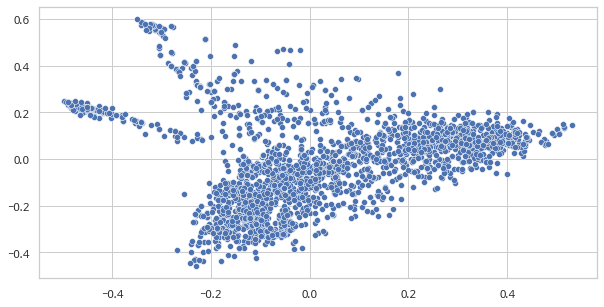

In [28]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x0, x1, data=c)

## KMeans

## inertia

In [29]:
kmeans_per_n = [KMeans(n_clusters=n, random_state=42).fit(X) for n in range(1, 10)]
inertia_list = [model.inertia_ for model in kmeans_per_n]

그림 저장:  한전기술_intertia


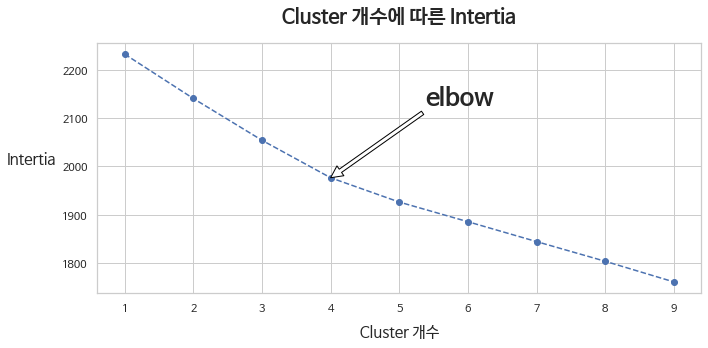

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 10), inertia_list, "bo--")
plt.annotate('elbow',
             xy=(4, inertia_list[3]),
             xytext=(0.6, .7),
             textcoords='figure fraction',
             fontsize=25, fontweight='bold',
             arrowprops=dict(facecolor='white', edgecolor='black')
            )
#title
title_style = {'fontsize': 20, 'fontweight': 'bold'}
plt.title('Cluster 개수에 따른 Intertia',pad=20,fontdict=title_style)

#set labels' style
plt.xlabel('Cluster 개수', fontsize=15, labelpad=10)
plt.ylabel('Intertia', fontsize=15, rotation=0, labelpad=30)

save_fig('한전기술_intertia')

In [32]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_n[1:]]

그림 저장:  한전기술_kmeans_silhouette


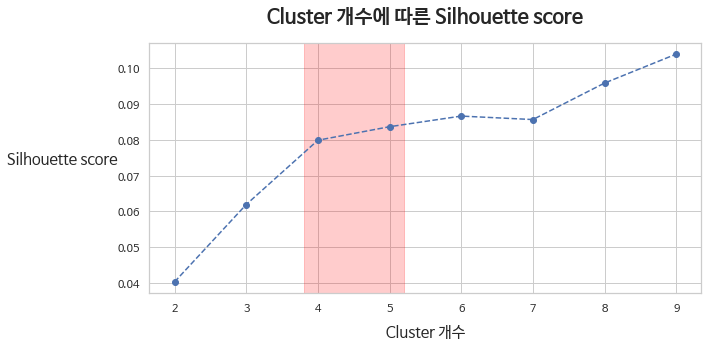

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), silhouette_scores, "bo--")

#title
title_style = {'fontsize': 20, 'fontweight': 'bold'}
plt.title('Cluster 개수에 따른 Silhouette score',pad=20,fontdict=title_style)

#set labels' style
plt.xlabel('Cluster 개수', fontsize=15, labelpad=10)
plt.ylabel("Silhouette score", fontsize=15, rotation=0, labelpad=55)

plt.axvspan(3.8, 5.2, color='red', alpha=0.2)  

save_fig('한전기술_kmeans_silhouette')

그림 저장:  한전기술_kmeans_silhouette_diagram


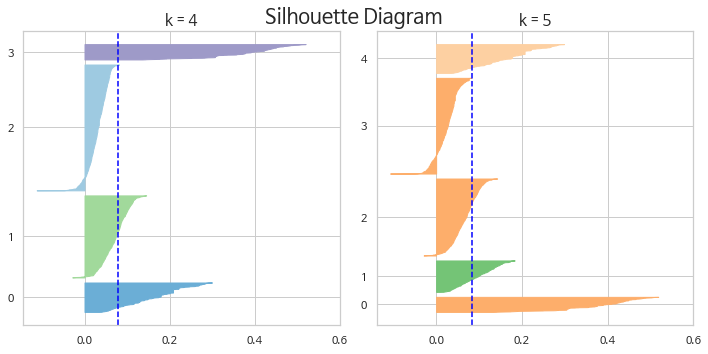

In [39]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import random

plt.figure(figsize=(10, 5))

for k in (4, 5):
    plt.subplot(1, 2, k-3).set_title(f'k = {k}', fontsize=15)
    plt.suptitle('Silhouette Diagram', fontsize=20)

    y_pred = kmeans_per_n[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X.toarray()) // 50
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        cmap = plt.get_cmap('tab20c')
        color = cmap(np.array(random.randrange(1, 15)))
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    plt.gca().set_xticks([0, 0.2, 0.4, 0.6])



    plt.axvline(x=silhouette_scores[k - 2], color="blue", linestyle="--")

  
save_fig('한전기술_kmeans_silhouette_diagram')

In [40]:
kmeans = KMeans(n_clusters=4, random_state=42, init = 'k-means++')
kmeans.fit(X)

KMeans(n_clusters=4, random_state=42)

In [41]:
c['kmeans'] = kmeans.labels_
c.tail()

,date,title,keyword,x0,x1,kmeans
2438,2021,한국전력기술 디지털엔지니어링 전담조직 구축,"[털엔지니어링, 한국판, 데이터, 프로젝트, 디지털화, 엔지니어링, 디지털, 엔지니...",-0.011618,0.016972,2
2439,2021,"""코로나 위기 뚫고 취업 성공했어요""","[코로나, 코로나, 코로나, 취업난, 대전여자상업고등학교, 대전여상, 재학중, 유예...",-0.170110,-0.318856,2
2440,2021,대구경북 상장 기업 시총 1년 새 10조원 늘었다,"[대구경북, 상장사, 글로벌, 투자자, 투자자, 포스코, 포스코케미칼, 가스공사, ...",-0.170657,0.097574,0
2441,2021,올봄 임기 만료되는 공공기관장 인사 큰장 선다,"[공공기관장, 산업통상, 자원부, 에너지, 기관장, 성윤모, 산업부, 조직개편, 산...",0.084127,-0.251554,2
2442,2021,"대전여상, 공공기관 합격자 14명 배출","[대전여상, 합격자, 대전시교육청, 대전여자상업고, 유예진, 조수민, 한국국제협력단...",-0.206911,-0.291475,2


In [42]:
def get_top_keywords(num, label=kmeans.labels_):
    df = pd.DataFrame(X.todense()).groupby(label).mean() # cluster에 따라 TF-IDF vector 그룹화
    keywords = tfidf.get_feature_names_out() 
    for i,r in df.iterrows():
        print(f'\nCluster_{i}')
        print(','.join([keywords[t] for t in np.argsort(r)[-num:]])) #상위 num개수만큼의 keyword


get_top_keywords(10)


Cluster_0
두산중공업,가능성,원자력,자동차,투자자,목표주가,외국인,코스피,매출액,거래량

Cluster_1
발전소,정재훈,원자로,uae,탈원전,에너지,한국수력원자력,두산중공업,한수원,원자력

Cluster_2
관계자,자회사,본부장,임직원,김천시,코로나,에너지,공기업,이배수,공공기관

Cluster_3
위원회,연구원,연구소,본부장,부사장,대표이사,장인상,장례식장,모친상,부친상


In [375]:
def get_title_by_cluster(df, label, model):
  for i in set(label):
    #DBSCAN에서 -1,0은 noise 또는 clustering이 잘 안된 경우
    if model == 'dbscan':
      if(i == -1):
        continue
      else:
        print(f'\nCluster_{i}')
        temp = df[df[model] == i]
        for title in temp['title'][:3]:
          print(title, sep='  ')
    else:
      print(f'\nCluster_{i}')
      temp = df[df[model] == i]
      for title in temp['title'][:4]:
         print(title)

In [44]:
get_title_by_cluster(c, kmeans.labels_, 'kmeans')


Cluster_0
한국테크놀로지, +3.37% 52주 신고가
하락률 상위 50선 - 코스피
하락률 상위 50선 - 코스피
24일 코스피 시장 공매도 비중 상위 종목. 아모레G, 한온시스템 등

Cluster_1
한전기술, 협력사와 지식재산권 실시허여 협약식
한국전력기술 협력사와 지식재산권 실시허여 협약 체결
멀쩡한 월성 1호기 영구정지 "전기료 인상 원전산업 붕괴" 우려
기업공시

Cluster_2
한국전력기술, 업(業)연계 中企 에너지 효율화 진단 실무협약 체결
한전기술, 업(業)연계 중기 에너지 효율화 진단 실무협약 ?
오스펌 레인보우브레인 상신플러스 쓰리엘코리아, '올해를 빛낸 기업' 선정
한국전력기술 제2차 인권경영위원회 열어

Cluster_3
[부고] 백한선씨 外
[부고] 강두만씨 外
부고
[부음] 이동수(LG화학 생명과학사업총괄 전무)씨 모친상 外


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


그림 저장:  한전기술_KMeans=4_scatterplot


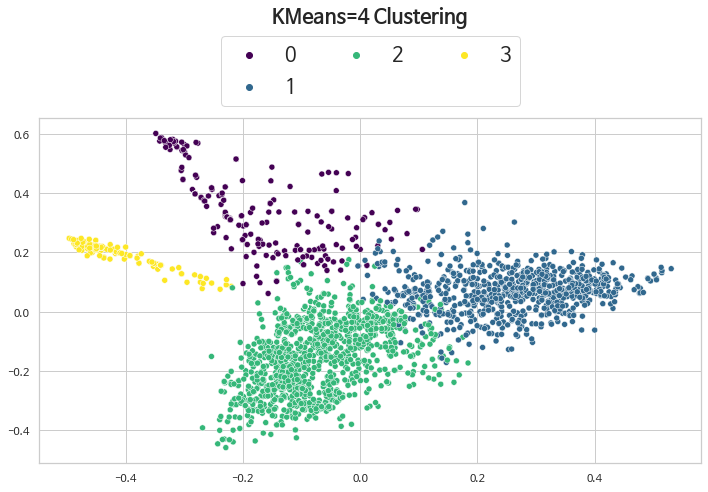

In [194]:
plt.figure(figsize=(10, 7))


sns.scatterplot(x0, x1, hue='kmeans', data=c, palette="viridis")
#title
title_style = {'fontsize': 20, 'fontweight': 'bold'}
plt.title('KMeans=4 Clustering',pad=95,fontdict=title_style)

plt.legend(
      loc='center',
       bbox_to_anchor=(0, 1.06, 1, 0.15),
       ncol=3, 
       fontsize=20)
save_fig('한전기술_KMeans=4_scatterplot')

## DBCSAN

### NearestNeighbors

https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc 

https://stats.stackexchange.com/questions/88872/a-routine-to-choose-eps-and-minpts-for-dbscan

In [272]:
from sklearn.metrics.cluster import homogeneity_score,completeness_score,v_measure_score

for i in range (1,10,1):
  model= DBSCAN(eps=i*0.1, min_samples=10)
  model.fit(X)
  labels = model.labels_
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise_ = list(labels).count(-1)
  print(f'\neps = {i*0.1}')
  print('Estimated number of clusters: %d' % n_clusters_)
  print('Estimated number of noise points: %d' % n_noise_)
  # print("Homogeneity: %0.3f" % homogeneity_score(y, labels))
  # print("Completeness: %0.3f" % completeness_score(y, labels))
  # print("V-measure: %0.3f" %v_measure_score(y, labels))


eps = 0.1
Estimated number of clusters: 8
Estimated number of noise points: 2282

eps = 0.2
Estimated number of clusters: 8
Estimated number of noise points: 2273

eps = 0.30000000000000004
Estimated number of clusters: 15
Estimated number of noise points: 2174

eps = 0.4
Estimated number of clusters: 23
Estimated number of noise points: 1984

eps = 0.5
Estimated number of clusters: 31
Estimated number of noise points: 1772

eps = 0.6000000000000001
Estimated number of clusters: 34
Estimated number of noise points: 1536

eps = 0.7000000000000001
Estimated number of clusters: 34
Estimated number of noise points: 1177

eps = 0.8
Estimated number of clusters: 26
Estimated number of noise points: 638

eps = 0.9
Estimated number of clusters: 4
Estimated number of noise points: 134


In [286]:
NN_per_n = [NearestNeighbors(n_neighbors=n, n_jobs= -1).fit(X) for n in range(1, 10)]
# inertia_list = [model.inertia_ for model in kmeans_per_n]

In [96]:
nn = NearestNeighbors(n_neighbors=4, n_jobs=-1).fit(X)

In [97]:
distances, indices = nn.kneighbors(X)

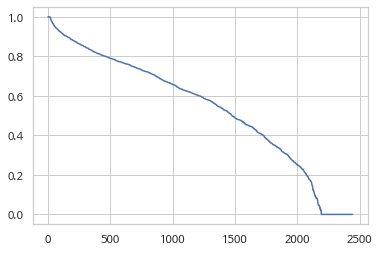

In [107]:
distance_desc = sorted(distances[:,3], reverse=True)
plt.plot(distance_desc)
#optimal epsilon 커브 많이 되는 지점에

In [108]:
kneeloc = KneeLocator(range(1,len(distance_desc)+1),  #x values
                      distance_desc, # y values
                      S=1.0, #parameter suggested from paper
                      curve="convex", #parameter from figure
                      direction="decreasing") #parameter from figure

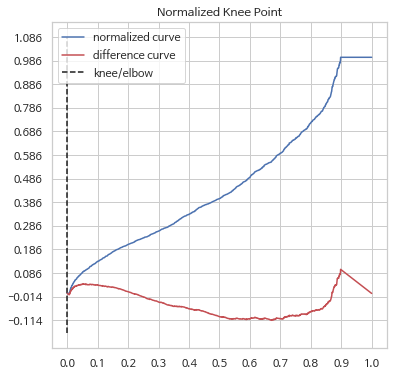

In [109]:
kneeloc.plot_knee_normalized()

In [110]:
kneeloc.knee_y

1.0

In [432]:
dbscan = DBSCAN(eps=0.3, min_samples=20, metric = "cosine")
#0.1 10
#0.3 10
#0.1 떨어진 거리 같은 cluster
#한 cluster에 적어도 10개의 sample이 모여야 함.
res = dbscan.fit_predict(X)

In [433]:
c['dbscan'] = dbscan.labels_
c

,date,title,keyword,x0,x1,kmeans,dbscan
0,2019,"한국전력기술, 업(業)연계 中企 에너지 효율화 진단 실무협약 체결","[에너지, 김천시, 김천상공회의소, 실무협약, 에너지, 중소기업, 에너지, 설비개선...",-0.062000,-0.250177,2,-1
1,2019,"한전기술, 업(業)연계 중기 에너지 효율화 진단 실무협약 ?","[실무협약, 에너지, 공공기관, 상생발전, 실무협약, 에너지, 민경학, 김천시, 윤...",-0.119417,-0.332113,2,8
2,2019,"한전기술, 협력사와 지식재산권 실시허여 협약식","[협력사, 지식재산권, 협약식, 무상제공, 지식재산권, 협약식, 이배수, 오크우드호...",0.076528,-0.062380,1,-1
3,2019,한국전력기술 협력사와 지식재산권 실시허여 협약 체결,"[협력사, 지식재산권, 이배수, 오크우드호텔, 원자력본부장, 대표자, 협약식, 지식...",0.076528,-0.062380,1,-1
4,2019,"한국테크놀로지, +3.37% 52주 신고가","[한국테크놀로지, 신고가, 한국테크놀로지, 신고가, 한국테크놀로지, 한전KPS, 우...",-0.104889,0.294359,0,0
...,...,...,...,...,...,...,...
2438,2021,한국전력기술 디지털엔지니어링 전담조직 구축,"[털엔지니어링, 한국판, 데이터, 프로젝트, 디지털화, 엔지니어링, 디지털, 엔지니...",-0.011618,0.016972,2,-1
2439,2021,"""코로나 위기 뚫고 취업 성공했어요""","[코로나, 코로나, 코로나, 취업난, 대전여자상업고등학교, 대전여상, 재학중, 유예...",-0.170110,-0.318856,2,-1
2440,2021,대구경북 상장 기업 시총 1년 새 10조원 늘었다,"[대구경북, 상장사, 글로벌, 투자자, 투자자, 포스코, 포스코케미칼, 가스공사, ...",-0.170657,0.097574,0,-1
2441,2021,올봄 임기 만료되는 공공기관장 인사 큰장 선다,"[공공기관장, 산업통상, 자원부, 에너지, 기관장, 성윤모, 산업부, 조직개편, 산...",0.084127,-0.251554,2,-1


In [434]:
len(c['dbscan'].unique())

16

In [435]:
explode = []
i = 0
for _ in range(len(c['dbscan'].unique())):
  explode.append(i)
  i += 0.2
  

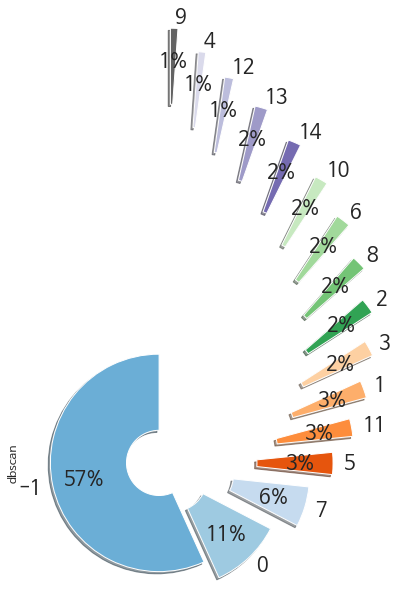

In [436]:
inside = c['dbscan'].value_counts()[:1]
outside = c['dbscan'].value_counts()[2:]

wedgeprops ={'width': 0.7, 'edgecolor': 'w'}

cmap = plt.get_cmap('tab20c')
colors = cmap(np.array(range(1, 40)))


c['dbscan'].value_counts().plot.pie(radius=1, colors=colors, startangle=90, pctdistance=0.7, explode=explode,
                wedgeprops=wedgeprops, autopct='%1.0f%%', shadow=True, figsize=(7, 5), fontsize=20)


In [437]:
#@title 기본 제목 텍스트
get_top_keywords(10, label=dbscan.labels_)


Cluster_-1
코로나,본부장,공기업,관계자,한국수력원자력,한수원,두산중공업,발전소,원자력,에너지

Cluster_0
두산중공업,가능성,자동차,투자자,원자력,목표주가,코스피,외국인,매출액,거래량

Cluster_1
원자력,프로그램,어려움,에너지,임직원,공기업,공공기관,코로나,캠페인,이배수

Cluster_2
한전kdn,코로나,두산중공업,한전kps,한전원자력연료,한국수력원자력,원자력,정재훈,간담회,한수원

Cluster_3
공기업,인프라,한국수력원자력,한국전력공사,경북도,프로그램,한국가스공사,관계자,한국도로공사,공공기관

Cluster_4
본부장,이사장,어려움,공공기관,업무협약,서비스,코로나,이배수,일자리,장애인

Cluster_5
공공기관,한전kps,일자리,한국전력공사,한국중부발전,한국남부발전,한국가스공사,기관장,한국마사회,공기업

Cluster_6
경쟁력,한전원자력연료,한국수력원자력,원전산업,두산중공업,한국원자력연구원,에너지,원자력,탈원전,신한울

Cluster_7
위원회,연구원,연구소,본부장,부사장,대표이사,장인상,장례식장,모친상,부친상

Cluster_8
온라인,지속적,중소기업,일자리,한국도로공사,코로나,공공기관,이배수,임직원,김천시

Cluster_9
한국수력원자력,한전원자력연료,아랍에미리트,신고리,uae,원자력,위원회,안전성,한수원,apr

Cluster_10
한전원자력연료,한전kps,한국수력원자력,공기업,한수원,위원회,한국전력공사,코로나,한국전력,자회사

Cluster_11
한국전력,관계자,우리나라,원자력,한수원,프로그램,아랍에미리트,apr,바라카,uae

Cluster_12
중소기업,플랫폼,한국전력공사,프로젝트,스마트,한국도로공사,부사장,엔지니어링,신재생,디지털

Cluster_13
uae,코로나,한국수력원자력,두산중공업,apr,정재훈,러시아,epc,한수원,이집트

Cluster_14
임직원,어려움,한전kps,한전원자력연료,한국남부발전,한국동서발전,한국전력,한국중부발전,한전kdn,코로나


In [438]:
get_title_by_cluster(c, dbscan.labels_, 'dbscan')


Cluster_0
한국테크놀로지, +3.37% 52주 신고가
하락률 상위 50선 - 코스피
하락률 상위 50선 - 코스피

Cluster_1
한국전력기술 농어촌상생협력기금 출연기업 감사패
한전기술, 2019년 농어촌상생협력기금 감사패 받아 ?
한국전력기술 동반성장위원장상 받아

Cluster_2
한수원, 원전 내진설계 기술력 제고 위한 워크숍
한수원, ‘원자력 유관기관 대표 소통 상생 간담회’ 개최
한수원, ‘원자력 유관기관 대표 간담회’ 개최

Cluster_3
금오공대, 1차 지역연계 협동 컨퍼런스 열어 '경상북도 지역선도대학 협의회' 구성 협약 체결
금오공대 컨소시엄, 제1차 지역연계 협동 컨퍼런스 열어
LG디스플레이 구미사업장 등 6곳 보건복지부서 지역사회공헌 인증

Cluster_4
저소득 재가 장애인 위한 행복 김치 만들기
중증재가장애인 나들이
재가장애인을 위한 나들이 진행

Cluster_5
4년새 공기업 순익 반토막 평균연봉은 11% 올라 7800만원
`신의 직장` 공기업, 작년 평균연봉 7842만원
작년 공기업 직원 평균연봉 7800만원 토 일 근무 마사회 9200만원 '연봉킹'

Cluster_6
“신한울 3 4호 건설 중단 땐
두산重 공장 가동률 추락
한수원 사명변경 검토안해

Cluster_7
[부고] 백한선씨 外
[부고] 강두만씨 外
부고

Cluster_8
한전기술, 업(業)연계 중기 에너지 효율화 진단 실무협약 ?
한국전력기술 노사화합 호프데이 열어
출산장려책 등 영향도 있지만, 일부지역선 ‘인구쟁탈전’ 풍선효과

Cluster_9
美 인증받은 한국형 원전 한국기술 설계력 '원더풀'
한수원 신형 경수로, 美 NRC 설계인증 취득
韓 차세대 원전, 美 수출길 열렸다

Cluster_10
적자 쌓이는데 한전 자회사, 공대 설립비용도 떠안나
적자 쌓이는데 한전 자회사, 공대 설립비용도 떠안나
한전, 美 증권거래위에 자회사 지분 매각 계획 신고

Cluster_11
[이제는 스마트 에너지 혁신시대 - 공기업 시리즈 ④에너지] 미국 원자력규

In [476]:
c.loc[:50]

,date,title,keyword,x0,x1,kmeans,dbscan
0,2019,"한국전력기술, 업(業)연계 中企 에너지 효율화 진단 실무협약 체결","[에너지, 김천시, 김천상공회의소, 실무협약, 에너지, 중소기업, 에너지, 설비개선...",-0.062000,-0.250177,2,-1
1,2019,"한전기술, 업(業)연계 중기 에너지 효율화 진단 실무협약 ?","[실무협약, 에너지, 공공기관, 상생발전, 실무협약, 에너지, 민경학, 김천시, 윤...",-0.119417,-0.332113,2,8
2,2019,"한전기술, 협력사와 지식재산권 실시허여 협약식","[협력사, 지식재산권, 협약식, 무상제공, 지식재산권, 협약식, 이배수, 오크우드호...",0.076528,-0.062380,1,-1
3,2019,한국전력기술 협력사와 지식재산권 실시허여 협약 체결,"[협력사, 지식재산권, 이배수, 오크우드호텔, 원자력본부장, 대표자, 협약식, 지식...",0.076528,-0.062380,1,-1
4,2019,"한국테크놀로지, +3.37% 52주 신고가","[한국테크놀로지, 신고가, 한국테크놀로지, 신고가, 한국테크놀로지, 한전KPS, 우...",-0.104889,0.294359,0,0
5,2019,"오스펌 레인보우브레인 상신플러스 쓰리엘코리아, '올해를 빛낸 기업' 선정","[오스펌, 레인보우브레인, 상신플러스, 쓰리엘코리아, 머니투데이, 시상식, 대한민국...",-0.068291,-0.129760,2,-1
6,2019,한국전력기술 제2차 인권경영위원회 열어,"[위원회, 이배수, 위원회, 파트너, 프로그램]",-0.102295,-0.181707,2,-1
7,2019,하락률 상위 50선 - 코스피,"[코스피, 코스피, 엔케이물산, 대한항공우, 한진칼우, 아모레G우, 두산솔루스우, ...",0.007715,0.317478,0,0
8,2019,하락률 상위 50선 - 코스피,"[코스피, 코스피, 엔케이물산, 대한항공우, 퍼스텍, 코오롱머티리얼, 아모레G우, ...",-0.048221,0.338898,0,0
9,2019,"24일 코스피 시장 공매도 비중 상위 종목. 아모레G, 한온시스템 등","[코스피, 공매도, 아모레G, 한온시스템, 코스피, 아모레G, 아모레, 공매도, 한...",-0.150291,0.487786,0,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


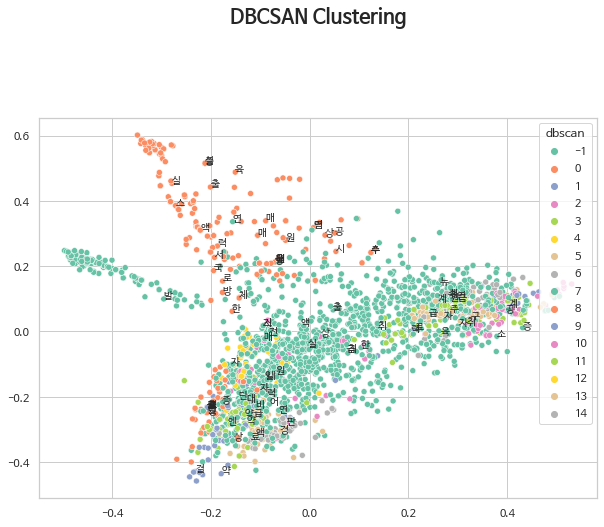

In [486]:
plt.figure(figsize=(10, 7))


sns.scatterplot(x0, x1, hue='dbscan', data=c, palette="Set2")
#title
title_style = {'fontsize': 20, 'fontweight': 'bold'}
plt.title('DBCSAN Clustering',pad=95,fontdict=title_style)

# for i, txt in enumerate(kepco_keyword_list[]):
#   plt.annotate(txt, (x0[i], x1[i]))